# 1.0 Baseline: TF-IDF + Logistic Regression

In [1]:
# Imports & global configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve

import random
import os

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

# Fixed random seed so all three methods share exactly the same splits
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

VAL_SIZE = 0.10
TEST_SIZE = 0.10

/Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/venv_dsa4263/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets from Hugging Face
DATASET_IMDB = "imdb"
DATASET_RT   = "rotten_tomatoes"

ds_imdb = load_dataset(DATASET_IMDB)
ds_rt   = load_dataset(DATASET_RT)

def to_df(ds, text_key="text", label_key="label"):
    """Convert a HF split to a simple pandas DataFrame."""
    return pd.DataFrame({
        "text":  ds[text_key],
        "label": ds[label_key],
    })

# IMDB
imdb_train_df = to_df(ds_imdb["train"])
imdb_test_df  = to_df(ds_imdb["test"])
imdb_full = pd.concat([imdb_train_df, imdb_test_df], ignore_index=True)

# Rotten Tomatoes
rt_train_df = to_df(ds_rt["train"])
rt_val_df   = to_df(ds_rt["validation"])
rt_test_df  = to_df(ds_rt["test"])
rt_full = pd.concat([rt_train_df, rt_val_df, rt_test_df], ignore_index=True)

print("IMDB full size:", len(imdb_full))
print("RT full size:", len(rt_full))
imdb_full.head()

IMDB full size: 50000
RT full size: 10662


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [3]:
# Create fixed 80/10/10 stratified splits
from typing import Tuple, Dict

def stratified_indices(df: pd.DataFrame,
                       val_size: float,
                       test_size: float,
                       seed: int) -> Dict[str, np.ndarray]:
    X = df.index.values
    y = df["label"].values

    # First split: train vs temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=val_size + test_size,
        stratify=y,
        random_state=seed,
    )

    # Second split: temp → val vs test
    rel_test = test_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=rel_test,
        stratify=y_temp,
        random_state=seed,
    )

    return {
        "train": np.sort(X_train),
        "val":   np.sort(X_val),
        "test":  np.sort(X_test),
    }

def apply_indices(df: pd.DataFrame, idx: Dict[str, np.ndarray]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    tr = df.loc[idx["train"]].reset_index(drop=True)
    va = df.loc[idx["val"]].reset_index(drop=True)
    te = df.loc[idx["test"]].reset_index(drop=True)
    return tr, va, te

imdb_idx = stratified_indices(imdb_full, VAL_SIZE, TEST_SIZE, SEED)
rt_idx   = stratified_indices(rt_full,   VAL_SIZE, TEST_SIZE, SEED)

imdb_tr, imdb_va, imdb_te = apply_indices(imdb_full, imdb_idx)
rt_tr,   rt_va,   rt_te   = apply_indices(rt_full,   rt_idx)

for name, (tr, va, te) in {
    "IMDB": (imdb_tr, imdb_va, imdb_te),
    "RT":   (rt_tr,  rt_va,  rt_te),
}.items():
    print(f"{name} splits - train: {len(tr)}, val: {len(va)}, test: {len(te)}")

IMDB splits - train: 40000, val: 5000, test: 5000
RT splits - train: 8529, val: 1066, test: 1067


In [4]:
# Baseline model: TF-IDF + Logistic Regression
def fit_and_eval_baseline(
    tag: str,
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    return_details: bool = False,
) -> dict:
    print(f"\nBaseline: {tag}")

    X_train_text = train_df["text"].tolist()
    y_train = train_df["label"].values

    X_test_text  = test_df["text"].tolist()
    y_test = test_df["label"].values

    vectorizer = TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        min_df=5,
        strip_accents="unicode",
        lowercase=True,
    )

    X_train = vectorizer.fit_transform(X_train_text)
    X_test  = vectorizer.transform(X_test_text)

    print(f"TF-IDF vocab size: {X_train.shape[1]:,}")

    clf = LogisticRegression(
        C=1.0,
        penalty="l2",
        solver="liblinear",
        max_iter=1000,
        class_weight=None,
        random_state=SEED,
    )

    clf.fit(X_train, y_train)

    # Evaluate on test set
    y_prob = clf.predict_proba(X_test)[:, 1]       # P(Positive)
    y_pred = (y_prob >= 0.5).astype(int)           # threshold 0.5

    acc   = accuracy_score(y_test, y_pred)
    f1m   = f1_score(y_test, y_pred, average="macro")
    brier = brier_score_loss(y_test, y_prob)

    print(f"Accuracy : {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")
    print(f"Brier   : {brier:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"])
    disp.plot(values_format="d")
    plt.title(f"Baseline: {tag} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Reliability curve
    frac_pos, mean_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")
    plt.figure()
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    plt.plot(mean_pred, frac_pos, marker="o", label="Baseline")
    plt.xlabel("Predicted probability (bin avg)")
    plt.ylabel("Empirical positive rate")
    plt.title(f"Baseline: {tag} Reliability Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    result = {
        "dataset": tag,
        "accuracy": acc,
        "macro_f1": f1m,
        "brier": brier,
        "n_test": len(y_test),
    }

    if return_details:
        result["y_test"] = y_test
        result["y_pred"] = y_pred
        result["y_prob"] = y_prob
        result["texts"]  = X_test_text

    return result


Baseline: IMDB
TF-IDF vocab size: 20,000
Accuracy : 0.9060
Macro-F1: 0.9060
Brier   : 0.0759

Classification report:
              precision    recall  f1-score   support

    Negative       0.92      0.89      0.90      2500
    Positive       0.90      0.92      0.91      2500

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



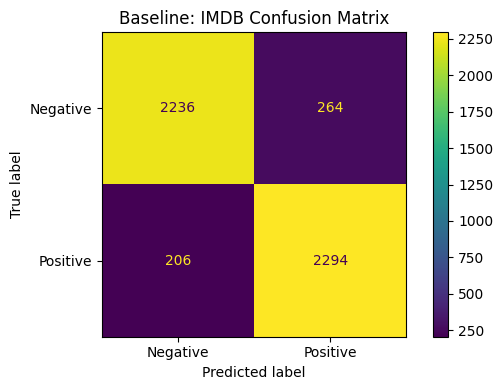

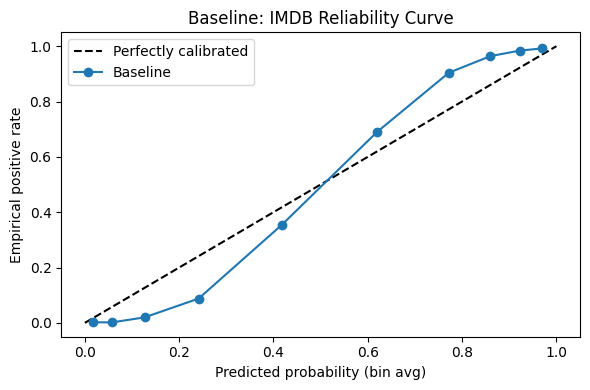


Baseline: Rotten Tomatoes
TF-IDF vocab size: 7,068
Accuracy : 0.7704
Macro-F1: 0.7704
Brier   : 0.1727

Classification report:
              precision    recall  f1-score   support

    Negative       0.78      0.76      0.77       534
    Positive       0.77      0.78      0.77       533

    accuracy                           0.77      1067
   macro avg       0.77      0.77      0.77      1067
weighted avg       0.77      0.77      0.77      1067



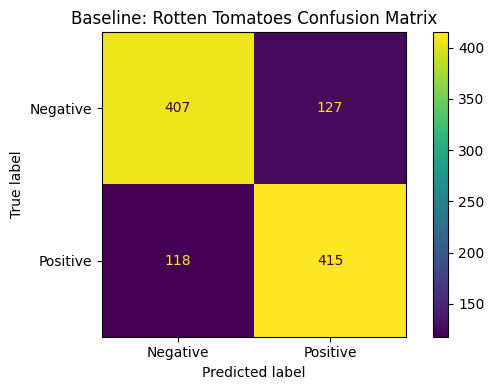

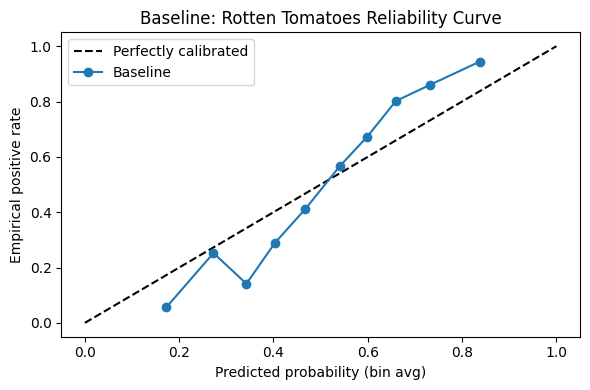

,dataset,accuracy,macro_f1,brier,n_test
0,IMDB,0.906000,0.905987,0.075932,5000
1,Rotten Tomatoes,0.770384,0.770371,0.172663,1067


In [5]:
# Run baseline method on both datasets
imdb_result = fit_and_eval_baseline("IMDB", imdb_tr, imdb_va, imdb_te, return_details=True)
rt_result   = fit_and_eval_baseline("Rotten Tomatoes", rt_tr, rt_va, rt_te, return_details=True)

# Small metrics table for the report
metrics_df = pd.DataFrame([
    {k: imdb_result[k] for k in ["dataset", "accuracy", "macro_f1", "brier", "n_test"]},
    {k: rt_result[k]   for k in ["dataset", "accuracy", "macro_f1", "brier", "n_test"]},
])
metrics_df

In [6]:
# Error analysis
def show_baseline_errors(tag: str, result: dict, n_examples: int = 10, max_chars: int = 400):
    texts  = result["texts"]
    y_true = result["y_test"]
    y_pred = result["y_pred"]
    y_prob = result["y_prob"]

    errors = []
    for text, yt, yp, p in zip(texts, y_true, y_pred, y_prob):
        if yt != yp:
            errors.append((text, yt, yp, p))

    print(f"\nMisclassified examples for {tag} (up to {n_examples}):\n")

    if not errors:
        print("No misclassified examples found.")
        return

    for i, (text, yt, yp, p) in enumerate(errors[:n_examples], 1):
        true_lbl = "Positive" if yt == 1 else "Negative"
        pred_lbl = "Positive" if yp == 1 else "Negative"

        snippet = text.replace("\n", " ")
        if len(snippet) > max_chars:
            snippet = snippet[:max_chars] + " ..."

        print(f"Example {i}:")
        print(f"  True label : {true_lbl}")
        print(f"  Pred label : {pred_lbl}")
        print(f"  P(Positive): {p:.3f}")
        print(f"  Text: {snippet}\n")

In [7]:
show_baseline_errors("IMDB", imdb_result, n_examples=10)
show_baseline_errors("Rotten Tomatoes", rt_result, n_examples=10)


Misclassified examples for IMDB (up to 10):

Example 1:
  True label : Negative
  Pred label : Positive
  P(Positive): 0.551
  Text: They constructed this one as a kind of fantasy Man From Snowy River meets Butch Cassidy and the Sundance kid, and just for a romantic touch Ned and Joe get to play away with high class talent, the bored young wives of wealthy older men. OK, there are lots of myths about Ned Kelly, but there are also a lot of well documented facts, still leaving space for artistic creativity in producing a good his ...

Example 2:
  True label : Negative
  Pred label : Positive
  P(Positive): 0.712
  Text: If the term itself were not geographically and semantically meaningless, one might well refer to "Ned Kelly" as an "Australian Western." For the people Down Under, Ned Kelly was, apparently, a folk hero bandit akin to Robin Hood, Jesse James, Bonnie and Clyde, and Butch Cassidy and the Sundance Kid. The descendant of Irish immigrants, Kelly became a fugitive and an outl